## Reproductible fitting 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy

from jmstate import MultiStateJointModel
from jmstate.utils import *

torch.manual_seed(42)

In [2]:
def log_weibull(t1, t0, lambda_, rho_):
    t = t1 - t0
    lambda_ = torch.as_tensor(lambda_, dtype=torch.float32)
    rho_ = torch.as_tensor(rho_, dtype=torch.float32)
    eps = 1e-8
    t = t + eps
    return torch.log(rho_ / lambda_) + (rho_ - 1) * torch.log(t / lambda_)


def double_slope(t, x, psi):
    x0 = psi[:, [0]]
    a = psi[:, [1]]
    b1 = psi[:, [2]]
    b2 = psi[:, [3]]
    corr = torch.where(t > x0, (b2 - b1) * (t - x0), torch.zeros_like(t))
    return (a + b1 * t + corr).unsqueeze(-1)


def double_slope_grad(t, x, psi):
    x0 = psi[:, [0]]
    b1 = psi[:, [2]]
    b2 = psi[:, [3]]
    return torch.where(t <= x0, b1, b2).unsqueeze(-1)


def link(t, x, psi):
    return torch.cat([double_slope(t, x, psi), double_slope_grad(t, x, psi)], dim=-1)


f = lambda gamma, b: gamma + b

In [3]:
##############################################

lambda_T01 = 6.335892481192901
rho_T01 = 1.909366627827557
lambda_T02 = 10.244190570369856
rho_T02 = 2.1623235907469036
lambda_T12 = 5.700891489358726
rho_T12 = 1.484804453708993

##############################################

gamma = torch.tensor([0.9566, 1.3329, -1.3877, 0.1774])
Q_inv = torch.diag(torch.tensor([1.2529, 0.3496, 0.5134, 0.7750]))
Q_sqrt = torch.matrix_exp(-Q_inv)
Q_inv = flat_from_tril(Q_inv)
R_inv = torch.tensor([1.1963])
R_sqrt = torch.exp(-R_inv)
alphas = {
    (0, 1): torch.tensor([0.0729, 5.1656]),
    (0, 2): torch.tensor([-0.1266, 4.8410]),
    (1, 2): torch.tensor([-0.0112, 0.1901]),
}
betas = {
    (0, 1): torch.tensor([-1.3434]),
    (0, 2): torch.tensor([-0.9148]),
    (1, 2): torch.tensor([-0.5497]),
}

##############################################

real_params = ModelParams(
    gamma,
    Q_inv,
    R_inv,
    alphas,
    betas
)

In [4]:
log_weibull_T01 = lambda t1, t0: log_weibull(t1, t0, lambda_T01, rho_T01)
log_weibull_T02 = lambda t1, t0: log_weibull(t1, t0, lambda_T02, rho_T02)
log_weibull_T12 = lambda t1, t0: log_weibull(t1, t0, lambda_T12, rho_T12)

surv = {
    (0, 1): (log_weibull_T01, link),
    (0, 2): (log_weibull_T02, link),
    (1, 2): (log_weibull_T12, link),
}

In [5]:
model_design = ModelDesign(
    f,
    double_slope,
    surv
)

In [6]:
real_model = MultiStateJointModel(model_design, real_params)

n, p = 2000, 1
t = torch.linspace(0, 17, 50)
c = torch.rand(n) * 19 + 1
x = 2 + torch.randn(n, 1) * torch.sqrt(torch.tensor(0.5))
b = torch.randn(n, real_params.gamma.shape[0]) @ Q_sqrt
psi = f(real_params.gamma, b)

In [7]:
trajectories_init = [[(0.0, 0)] for _ in range(n)]

sample_data = SampleData(
    x,
    trajectories_init,
    psi
)

trajectories = real_model.sample_trajectories(sample_data, c)

In [8]:
c_min = torch.tensor(
    [
        (
            min(c[i].item(), trajectories[i][-1][0])
            if trajectories[i][-1][1] == 2
            else c[i].item()
        )
        for i in range(len(trajectories))
    ]
)

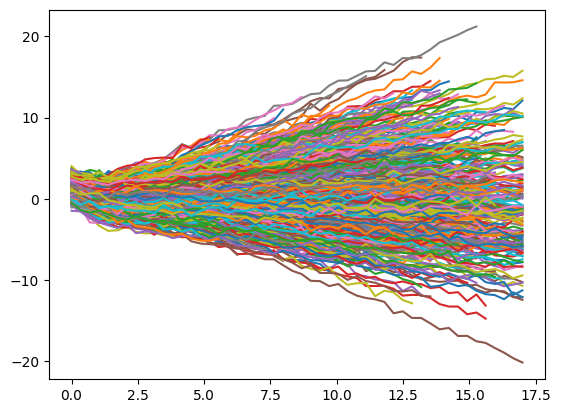

In [9]:
y = model_design.h(t, x, psi)
y += torch.randn_like(y) * R_sqrt
y[t.repeat(n, 1) > c_min.view(-1, 1)] = torch.nan
plt.plot(t, y.squeeze(-1).T)
plt.show()

In [10]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    torch.zeros_like(Q_inv),
    torch.zeros_like(R_inv),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()}
)

model = MultiStateJointModel(model_design, init_params)

In [11]:
data = ModelData(
    x,
    t,
    y,
    trajectories,
    c
)

In [12]:
history = []
acceptance = []
step_sizes = []

def callback():
    history.append([p.detach().clone() for p in model.params_.as_list])
    acceptance.append(model.sampler_.acceptance_rate)
    step_sizes.append(model.sampler_.step_size)

model.fit(data, n_iter=2000, callback=callback)

Computing Fisher Information Matrix: 100%|██████████| 1000/1000 [00:46<00:00, 21.57it/s]


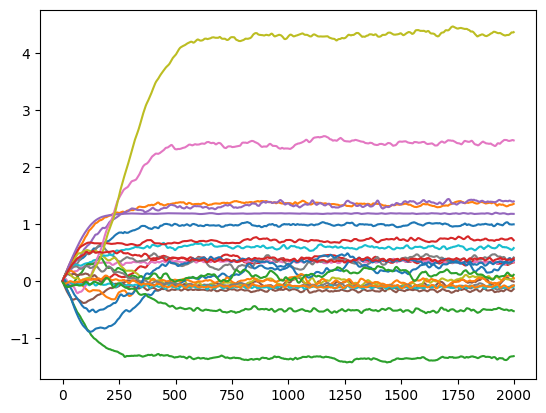

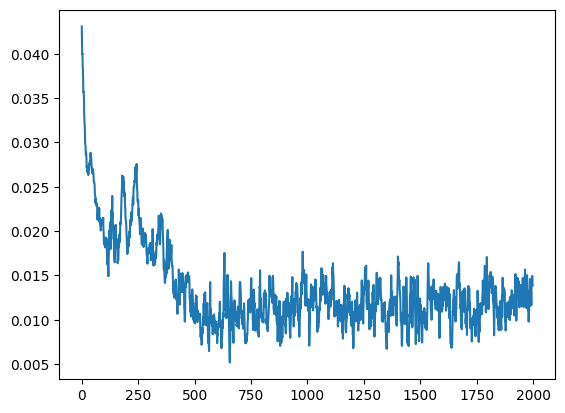

In [13]:
history_vstack = np.vstack([np.hstack([p.numpy().reshape(1, -1) for p in elt]) for elt in history])
plt.plot(np.arange(history_vstack.shape[0]), history_vstack)
plt.show()

plt.plot(np.arange(history_vstack.shape[0] - 1), np.linalg.norm(np.diff(history_vstack, axis=0), axis=1))
plt.show()

In [14]:
print(model.params_)
print(model.get_stderror())

ModelParams(gamma=tensor([ 0.9956,  1.3547, -1.3137,  0.3276], requires_grad=True), Q_inv=tensor([ 1.3966, -0.0079,  0.3405,  0.4151,  0.0443,  0.5792,  0.3687,  0.0529,
         0.1111,  0.7175], requires_grad=True), R_inv=tensor([1.1783], requires_grad=True), alphas={(0, 1): tensor([-0.1374,  2.4654], requires_grad=True), (0, 2): tensor([-0.0740,  4.3612], requires_grad=True), (1, 2): tensor([-0.0978,  0.3716], requires_grad=True)}, betas={(0, 1): tensor([-0.0768], requires_grad=True), (0, 2): tensor([-0.5265], requires_grad=True), (1, 2): tensor([0.3954], requires_grad=True)})
ModelParams(gamma=tensor([0.0045, 0.0096, 0.0116, 0.0011]), Q_inv=tensor([0.0353, 0.0710, 0.0426, 0.0945, 0.0961, 0.0386, 0.1003, 0.1129, 0.1107,
        0.0380]), R_inv=tensor([0.0096]), alphas={(0, 1): tensor([0.0295, 0.1472]), (0, 2): tensor([0.0713, 0.2384]), (1, 2): tensor([0.0558, 0.2996])}, betas={(0, 1): tensor([0.0267]), (0, 2): tensor([0.0861]), (1, 2): tensor([0.0933])})


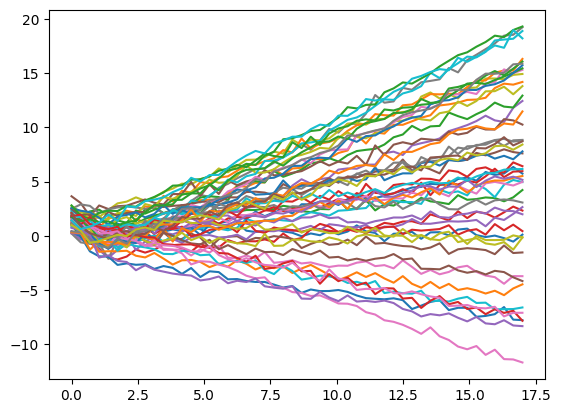

In [15]:
N = 50

Q = tril_from_flat(model.params_.Q_inv, model.params_.Q_dim_).detach()
Q = torch.linalg.inv(precision_from_log_cholesky(Q))

R = tril_from_flat(model.params_.R_inv, model.params_.R_dim_).detach()
R = torch.linalg.inv(precision_from_log_cholesky(R))

b_sim = torch.randn(N, model.params_.gamma.detach().shape[0]) @ torch.tensor(scipy.linalg.sqrtm(Q.numpy()))
psi_sim = f(model.params_.gamma, b_sim)
x_sim = 2 + torch.randn(N, 1) * torch.sqrt(torch.tensor(0.5))

y_sim = model.model_design.h(t, x_sim, psi_sim)
y_sim += torch.randn_like(y_sim) @ torch.tensor(scipy.linalg.sqrtm(R.numpy()))
plt.plot(t, y_sim.squeeze(-1).T.detach().numpy())
plt.show()

In [16]:
trajectories_init = [trajectory[:1] for trajectory in trajectories[:N]]

sample_data = SampleData(x_sim, trajectories_init, psi_sim)

trajectories_sim = model.sample_trajectories(sample_data, [95.0 for _ in range(N)])

In [17]:
print(trajectories_sim)

[[(0.0, 0), (7.4813079833984375, 1), (12.208727836608887, 2)], [(0.0, 0), (1.9496917724609375, 1), (2.5233051776885986, 2)], [(0.0, 0), (6.934814453125, 1), (8.32292652130127, 2)], [(0.0, 0), (4.7314453125, 1), (9.355340957641602, 2)], [(0.0, 0), (2.55706787109375, 1), (2.5866899490356445, 2)], [(0.0, 0), (3.93707275390625, 1), (9.963377952575684, 2)], [(0.0, 0), (6.613006591796875, 1), (7.907737731933594, 2)], [(0.0, 0), (1.6046905517578125, 2)], [(0.0, 0), (1.3321685791015625, 2)], [(0.0, 0), (1.6336822509765625, 1), (2.5369150638580322, 2)], [(0.0, 0), (1.8627166748046875, 1), (5.978402137756348, 2)], [(0.0, 0), (1.14227294921875, 2)], [(0.0, 0), (1.6713714599609375, 2)], [(0.0, 0), (7.0609283447265625, 2)], [(0.0, 0), (3.1470489501953125, 1), (4.819116115570068, 2)], [(0.0, 0), (4.4342803955078125, 1), (7.098628520965576, 2)], [(0.0, 0), (6.1534881591796875, 1), (7.5891642570495605, 2)], [(0.0, 0), (10.555877685546875, 2)], [(0.0, 0), (0.7233428955078125, 1), (2.800605535507202, 2)